https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline 

import utility.utility as ut
from preprocessing.createSets import *
from preprocessing.Sets import Sets
from utility.ML import ML

In [2]:
########### switches ################################

saveName='Oct23-2018_3'
saveFolder = saveName
saveplots=False
createSubmit = False

In [3]:
if not os.path.exists(saveFolder) and (saveplots or createSubmit): 
    print 'creating folder:',os.getcwd()+'/'+saveFolder
    os.mkdir(saveFolder)
if(saveplots): print "SAVING PLOTS!"
if(createSubmit): print "WILL CREATE SUBMIT FILE!"

############# Options/Args #########################

verbose=False
lag_length = 5
add_diff = True
add_isItemNew = True
add_price_range = True
    
opt = {
        'verbose':verbose,
        'lag_length':lag_length,
        'diff':add_diff,
        } 


#clipTarget
lowerClip = 0
upperClip = 20

########################################################

In [4]:
Sets = Sets(**opt)

dup_ids = Sets.checkDuplicates()
Sets.convertDatetime()
Sets.translateItemCategoryId()
Sets.addItemCategoryId()
Sets.addTranslatedItemCategoryId()
Sets.addYMcolumn()
bin_edges=[-0.01,0.01,10,100,200,500,1000,2500,5000,20000,999999]
Sets.binPrice(bin_edges)
Sets.splitDataByYear()
data = Sets.getData()


lag_length: 5
diff: True



In [5]:
train = data['sales_train']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,eng_cat_id,year,month,Y_M,price_range
0,2013-01-02,0,59,22154,999.00,1.0,37,Movie,2013,1,2013_1,"(500.0, 1000.0]"
1,2013-01-03,0,25,2552,899.00,1.0,58,Music,2013,1,2013_1,"(500.0, 1000.0]"
2,2013-01-05,0,25,2552,899.00,-1.0,58,Music,2013,1,2013_1,"(500.0, 1000.0]"
3,2013-01-06,0,25,2554,1709.05,1.0,58,Music,2013,1,2013_1,"(1000.0, 2500.0]"
4,2013-01-15,0,25,2555,1099.00,1.0,56,Music,2013,1,2013_1,"(1000.0, 2500.0]"


### Pivot to obtain aggregated values from all date blocks per shop_id, item_id, all in one go

In [6]:
#by item cnt 
item_cnt = train.pivot_table(index=['shop_id','item_id'],columns=['date_block_num'],values='item_cnt_day',aggfunc='sum')
item_cnt.fillna(0.0,inplace=True)
item_cnt = item_cnt.reset_index()
item_cnt = item_cnt.rename_axis("", axis="columns") #removes "date_block_num" as index name.

#item cnt diff`
item_diff = item_cnt[['shop_id','item_id']]
for i in range(1,34):
    item_diff = item_diff.assign(**{'{}-{}'.format(i,i-1): item_cnt[i]-item_cnt[i-1]})

#by item price
item_price = train.pivot_table(index=['shop_id','item_id'],columns=['date_block_num'],values='item_price',aggfunc='min')
item_price.fillna(0.0,inplace=True)
item_price = item_price.reset_index()
item_price = item_price.rename_axis(" ", axis="columns") #removes "date_block_num" as index name.

#isItemNew --> (if no price tag for the past 2 months == NEW)
isItemNew = item_price[['shop_id','item_id']].copy()
for i in range(2,34): 
    isItemNew['isItemNew_{}'.format(i)] = np.where(((item_price[i-1]==0) & (item_price[i-2]==0)), 'Yes','No')
    #isItemNew['isItemNew_{}'.format(i)] = np.where(((item_price[i]>0) & (item_price[i-1]==0) & (item_price[i-2]==0)), 'Yes','No') --> This causes target leak possibly!
    #label encode isItemnew 
    isItemNew['isItemNew_{}'.format(i)] = isItemNew['isItemNew_{}'.format(i)].astype('category')
    isItemNew['isItemNew_{}'.format(i)] = isItemNew['isItemNew_{}'.format(i)].cat.codes

# price range
price_range = item_price[['shop_id','item_id']].copy()
for i in range(0,34): 
    price_range['price_range_{}'.format(i)] = Sets.binPrice_v2(bin_edges,item_price,i)
    #label encode price_range 
    price_range['price_range_{}'.format(i)] = price_range['price_range_{}'.format(i)].cat.codes


In [7]:
item_diff.head()

,shop_id,item_id,1-0,2-1,3-2,4-3,5-4,6-5,7-6,8-7,...,24-23,25-24,26-25,27-26,28-27,29-28,30-29,31-30,32-31,33-32
0,0,30,31.0,-31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,11.0,-11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,4.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,13.0,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
item_price.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,434.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,221.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,247.0,247.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
isItemNew.head()

,shop_id,item_id,isItemNew_2,isItemNew_3,isItemNew_4,isItemNew_5,isItemNew_6,isItemNew_7,isItemNew_8,isItemNew_9,...,isItemNew_24,isItemNew_25,isItemNew_26,isItemNew_27,isItemNew_28,isItemNew_29,isItemNew_30,isItemNew_31,isItemNew_32,isItemNew_33
0,0,30,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,31,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0,32,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,33,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,35,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [10]:
price_range.head()

,shop_id,item_id,price_range_0,price_range_1,price_range_2,price_range_3,price_range_4,price_range_5,price_range_6,price_range_7,...,price_range_24,price_range_25,price_range_26,price_range_27,price_range_28,price_range_29,price_range_30,price_range_31,price_range_32,price_range_33
0,0,30,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,4,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,4,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,4,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:

df = item_cnt #to be merged with test

#Add item category id
item_id = data['items'][['item_id','item_category_id']]
item_cat = data['item_categories'][['item_category_id','eng_cat_id']]
df =  pd.merge(df,item_id,on='item_id',how='left')
df =  pd.merge(df,item_cat,on='item_category_id',how='left')

#rearrange columns
df = df[['shop_id', 'item_id','item_category_id', 'eng_cat_id'] + list(range(34))]
start_of_lag_cols = 4

#add diff columns 
if(add_diff):df = pd.concat([df,item_diff.iloc[:,2:]],axis=1)

#add isItemNew columns
if(add_isItemNew):df = pd.concat([df,isItemNew.iloc[:,2:]],axis=1)

#add price_range columns
if(add_price_range):df = pd.concat([df,price_range.iloc[:,2:]],axis=1)
    
    
#Label encode categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df[['eng_cat_id']] = number.fit_transform(df.eng_cat_id)

print df.shape
df.head() 

(424124, 137)


,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,5,...,price_range_24,price_range_25,price_range_26,price_range_27,price_range_28,price_range_29,price_range_30,price_range_31,price_range_32,price_range_33
0,0,30,40,7,0.0,31.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,37,7,0.0,11.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,40,7,6.0,10.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,37,7,3.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,40,7,1.0,14.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#Generate y_m : date_block_num dict.
y_m = data['sales_train']['Y_M'].unique()
d_b_n = data['sales_train']['date_block_num'].unique()
date_block_num_dict = dict(zip(y_m,d_b_n))

# Create train/val dataset

In [13]:
train_blocks =['2015_10','2015_9','2015_8','2013_11','2013_10']
val_block = '2014_11'

In [14]:
x_tr_list = []
y_tr_list = []
for y_m in train_blocks:
    x_train_,y_train_ = Sets.createDateblockSet(df,date_block_num_dict[y_m],start_of_lag_cols,lag_length=5)
    x_train_ = Sets.addDiff(x_train_,item_diff,date_block_num_dict[y_m],start_of_lag_cols,lag_length=5)
#     x_train_ = Sets.add_isItemNew(x_train_,isItemNew,date_block_num_dict[y_m],start_of_lag_cols,lag_length=0)
#     x_train_ = Sets.add_price_range(x_train_2,price_range,date_block_num_dict[y_m],start_of_lag_cols,lag_length=5)
    x_train_.head()

    x_tr_list.append(x_train_)
    y_tr_list.append(y_train_)

x_train = pd.concat(x_tr_list,axis=0)
y_train = pd.concat(y_tr_list,axis=0)

x_train.reset_index(inplace=True)
x_train.drop(columns='index',inplace=True)
#y_train.reset_index(inplace=True)

(424124, 10)
(424124, 10)
(424124, 10)
(424124, 10)
(424124, 10)


In [15]:
x_val,y_val = Sets.createDateblockSet(df,date_block_num_dict[val_block],start_of_lag_cols,lag_length=5)
x_val = Sets.addDiff(x_val,item_diff,date_block_num_dict[val_block],start_of_lag_cols,lag_length=5)
# x_val = Sets.add_isItemNew(x_val,isItemNew,date_block_num_dict[val_block],start_of_lag_cols,lag_length=0)
# x_val = Sets.add_price_range(x_val,price_range,date_block_num_dict[val_block],start_of_lag_cols,lag_length=5)

(424124, 10)


# Target encode with KFold reg

In [16]:
#Regularize target encoding
from sklearn.model_selection import KFold
kf = KFold(5,shuffle=True,random_state=1234)

targ_enc_dict = {}
targ_enc_dict['shop_id'] = 'cnt_by_shop_id'
targ_enc_dict['item_id'] = 'cnt_by_item_id'
targ_enc_dict['item_category_id'] = 'cnt_by_item_cat_id'
targ_enc_dict['eng_cat_id'] = 'mean_cnt_by_item_cat_eng'
df_enc_kFold = pd.concat([x_train.loc[:,'item_cnt_lag_0'],x_train.loc[:,targ_enc_dict.keys()]],axis=1)

for k,v in targ_enc_dict.items():
    for tr_ind,val_ind in kf.split(df_enc_kFold):
        df_tr, df_val = df_enc_kFold.iloc[tr_ind,:],df_enc_kFold.iloc[val_ind,:]
        if('mean'  in v):
            feat_target_sum = df_tr.groupby([k])['item_cnt_lag_0'].mean()
        else:
            feat_target_sum = df_tr.groupby([k])['item_cnt_lag_0'].sum()            
        df_val[v+'_kFold'] = df_val[k].map(feat_target_sum)  
        df_val[v+'_kFold'].fillna(0.0, inplace=True)
        df_enc_kFold.loc[val_ind,v+'_kFold'] = df_val[v+'_kFold']

print df_enc_kFold.shape
df_enc_kFold.head()

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(2120620, 9)


,item_cnt_lag_0,item_id,item_category_id,shop_id,eng_cat_id,cnt_by_item_id_kFold,cnt_by_item_cat_id_kFold,cnt_by_shop_id_kFold,mean_cnt_by_item_cat_eng_kFold
0,0.0,30,40,0,7,66.0,58502.0,0.0,0.123729
1,0.0,31,37,0,7,107.0,19942.0,0.0,0.122335
2,0.0,32,40,0,7,189.0,57927.0,0.0,0.123103
3,0.0,33,37,0,7,69.0,19942.0,0.0,0.122335
4,0.0,35,40,0,7,0.0,58502.0,0.0,0.123729


In [17]:
#merge target encodings to x_train:
# x_train = pd.concat([x_train,df_enc_kFold['cnt_by_shop_id_kFold']],axis=1)
# x_train = pd.concat([x_train,df_enc_kFold['cnt_by_item_id_kFold']],axis=1)
# x_train = pd.concat([x_train,df_enc_kFold['cnt_by_item_cat_id_kFold']],axis=1)
# x_train = pd.concat([x_train,df_enc_kFold['mean_cnt_by_item_cat_eng_kFold']],axis=1)

print x_train.shape
x_train.head()

(2120620, 15)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#set up mean target encodings for merge to x_val and x_test
df_enc_kFold_shop = df_enc_kFold.groupby(['shop_id','item_id'])['cnt_by_shop_id_kFold'].mean()
df_enc_kFold_item = df_enc_kFold.groupby(['shop_id','item_id'])['cnt_by_item_id_kFold'].mean()
df_enc_kFold_item_cat = df_enc_kFold.groupby(['shop_id','item_id'])['cnt_by_item_cat_id_kFold'].mean()
df_enc_kFold_item_cat_eng = df_enc_kFold.groupby(['shop_id','item_id'])['mean_cnt_by_item_cat_eng_kFold'].mean()

In [19]:
#merge (mean) target encodings to x_val:
# x_val = pd.merge(x_val,df_enc_kFold_shop.to_frame(),on=['shop_id','item_id'],how='left')
# x_val = pd.merge(x_val,df_enc_kFold_item.to_frame(),on=['shop_id','item_id'],how='left')
# x_val = pd.merge(x_val,df_enc_kFold_item_cat.to_frame(),on=['shop_id','item_id'],how='left')
# x_val = pd.merge(x_val,df_enc_kFold_item_cat_eng.to_frame(),on=['shop_id','item_id'],how='left')
print x_val.shape
x_val.head()

(424124, 15)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# drop target
x_train  = x_train.drop(columns='item_cnt_lag_0')
x_val  = x_val.drop(columns='item_cnt_lag_0')

# Clip y_train, y_val

In [21]:
y_train,y_val = Sets.clipSalesCount(y_train,y_val,lowerClip,upperClip)


Clipping train and val targets [0-20]



# Create features for test data

In [22]:
#merge test with our pivoted table
test_df = data['test'].merge(df, how = "left", on = ["shop_id", "item_id"])

#label encode price_range again : to fix the nans -> -1 (rather than 0)
# for i in range(34): test_df['price_range_{}'.format(i)] = test_df['price_range_{}'.format(i)].codes

#label encode isItemnew again : to fix the nans -> -1 (rather than 0)
# for i in range(2,34): 
#     test_df['isItemNew_{}'.format(i)] = test_df['isItemNew_{}'.format(i)].astype('category')
#     test_df['isItemNew_{}'.format(i)] = test_df['isItemNew_{}'.format(i)].codes

In [23]:
test_df.head()

,ID,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,...,price_range_24,price_range_25,price_range_26,price_range_27,price_range_28,price_range_29,price_range_30,price_range_31,price_range_32,price_range_33
0,0,5,5037,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,6.0,6.0,6.0,5.0,5.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,5.0,6.0
3,3,5,5232,23.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#clean up
test_df = test_df.fillna(0.0)

In [25]:
test_df.head()

,ID,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,...,price_range_24,price_range_25,price_range_26,price_range_27,price_range_28,price_range_29,price_range_30,price_range_31,price_range_32,price_range_33
0,0,5,5037,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,6.0,6.0,6.0,5.0,5.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,5.0,6.0
3,3,5,5232,23.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
x_test = Sets.createFeaturesForTest(test_df,start_of_lag_cols,lag_length=5)
x_test = Sets.addDiff_forTest(x_test,test_df,lag_length=5)
# x_test = Sets.add_price_range_forTest(x_test,test_df,lag_length=5)
# x_test = Sets.add_isItemNew_forTest(x_test,test_df,lag_length=0)

# merge target encoding
# x_test = x_test.merge(df_enc_kFold_shop.to_frame(),how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
# x_test = x_test.merge(df_enc_kFold_item.to_frame(),how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
# x_test = x_test.merge(df_enc_kFold_item_cat.to_frame(),how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
# x_test = x_test.merge(df_enc_kFold_item_cat_eng.to_frame(),how = "left", on = ["shop_id", "item_id"]).fillna(0.0)

print x_test.shape
x_test.head()

(214200, 9)
(214200, 14)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,5,5037,19.0,5.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,-2.0,-1.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,5.0,2.0,0.0,1.0,3.0,1.0,-1.0,-2.0,1.0,2.0,-2.0
3,5,5232,23.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#remove features from test if necessary
# col_to_drop = ['price_range_lag_{}'.format(i) for i in range(1,6)]
# x_test.drop(columns=col_to_drop,inplace=True)
# print x_test.shape
# x_test.head()

# Add feature interaction

In [28]:
# # item_category_isItemNew
# x_train['item_category_isItemNew'] = (str(x_train['item_category_id'])+'_'+str(x_train['isItemNew_lag_0']))
# x_train['item_category_isItemNew'] = x_train['item_category_isItemNew'].astype('category')
# # x_train['item_category_isItemNew'] = x_train['item_category_isItemNew'].cat.codes

# x_train['eng_cat_id_isItemNew'] = (str(x_train['eng_cat_id'])+'_'+str(x_train['isItemNew_lag_0']))
# x_train['eng_cat_id_isItemNew'] = x_train['eng_cat_id_isItemNew'].astype('category')
# # x_train['eng_cat_id_isItemNew'] = x_train['eng_cat_id_isItemNew'].cat.codes

# x_val['item_category_isItemNew'] = (str(x_val['item_category_id'])+'_'+str(x_val['isItemNew_lag_0']))
# x_val['item_category_isItemNew'] = x_val['item_category_isItemNew'].astype('category')
# # x_val['item_category_isItemNew'] = x_val['item_category_isItemNew'].cat.codes

# x_val['eng_cat_id_isItemNew'] = (str(x_val['eng_cat_id'])+'_'+str(x_val['isItemNew_lag_0']))
# x_val['eng_cat_id_isItemNew'] = x_val['eng_cat_id_isItemNew'].astype('category')
# # x_val['eng_cat_id_isItemNew'] = x_val['eng_cat_id_isItemNew'].cat.codes

# x_test['item_category_isItemNew'] = (str(x_test['item_category_id'])+'_'+str(x_test['isItemNew_lag_0']))
# x_test['item_category_isItemNew'] = x_test['item_category_isItemNew'].astype('category')
# # x_test['item_category_isItemNew'] = x_train['item_category_isItemNew'].cat.codes

# x_test['eng_cat_id_isItemNew'] = (str(x_test['eng_cat_id'])+'_'+str(x_test['isItemNew_lag_0']))
# x_test['eng_cat_id_isItemNew'] = x_test['eng_cat_id_isItemNew'].astype('category')
# # x_test['eng_cat_id_isItemNew'] = x_test['eng_cat_id_isItemNew'].cat.codes



In [29]:
# #remove features from test if necessary
# col_to_drop = ['eng_cat_id','isItemNew_lag_0']
# x_train.drop(columns=col_to_drop,inplace=True)
# x_val.drop(columns=col_to_drop,inplace=True)
# x_test.drop(columns=col_to_drop,inplace=True)
# print x_test.shape
# x_test.head()

### Standard Checks

In [30]:
print 'x_train.shape:',x_train.shape
print 'y_train.shape:',y_train.shape
print 'x_val.shape:',x_val.shape
print 'y_val.shape:',y_val.shape
print 'x_test.shape:',x_test.shape 
print 'x_test columns:' 
for i,col in enumerate(x_test.columns.values): print ' '*3,i,col 
print
print (set(x_train.columns.values)-set(x_test.columns.values))
assert (set(x_train.columns.values)-set(x_test.columns.values)==set([])), "train/val has more features than test!"

x_train.shape: (2120620, 14)
y_train.shape: (2120620,)
x_val.shape: (424124, 14)
y_val.shape: (424124,)
x_test.shape: (214200, 14)
x_test columns:
    0 shop_id
    1 item_id
    2 item_category_id
    3 eng_cat_id
    4 item_cnt_lag_5
    5 item_cnt_lag_4
    6 item_cnt_lag_3
    7 item_cnt_lag_2
    8 item_cnt_lag_1
    9 item_cnt_diff_lag_5
    10 item_cnt_diff_lag_4
    11 item_cnt_diff_lag_3
    12 item_cnt_diff_lag_2
    13 item_cnt_diff_lag_1

set([])


# Model Training

In [31]:
### Boosted Decision Tree (lightgbm)
import lightgbm as lgb

In [32]:
dataset = {
            'x_train':x_train,
            'x_val':x_val,

            'y_train':y_train,
            'y_val':y_val,

            'x_test':x_test,
            }

ml = ML(**dataset)

model,evals_result = ml.runBDT_lightgbm(
                    lgb_params = {
                                   'num_leaves': 2*7,
                                   'min_data_in_leaf': 2**7, 
                                   'max_depth': 8,
                                   'learning_rate': 0.03, 
                                   'objective': 'mse', 
                                   'metric': 'rmse',
                                   'nthread':4, 
                                   'feature_fraction': .75,
                                   'bagging_fraction': 0.75,#0.75 
                                   'bagging_freq':1,
                                   'bagging_seed': 2**7, 
                                   'verbose':1,
                                  }
                                        )

Training until validation scores don't improve for 200 rounds.
[50]	train's rmse: 0.835083	eval's rmse: 0.999064
[100]	train's rmse: 0.815395	eval's rmse: 0.982352
[150]	train's rmse: 0.809948	eval's rmse: 0.977416
[200]	train's rmse: 0.806792	eval's rmse: 0.974657
[250]	train's rmse: 0.804573	eval's rmse: 0.973258
[300]	train's rmse: 0.802741	eval's rmse: 0.972294
[350]	train's rmse: 0.801307	eval's rmse: 0.971926
[400]	train's rmse: 0.800069	eval's rmse: 0.971881
[450]	train's rmse: 0.798874	eval's rmse: 0.971636
[500]	train's rmse: 0.797726	eval's rmse: 0.971676
[550]	train's rmse: 0.796803	eval's rmse: 0.971558
[600]	train's rmse: 0.796008	eval's rmse: 0.97129
[650]	train's rmse: 0.795174	eval's rmse: 0.971423
[700]	train's rmse: 0.79438	eval's rmse: 0.971414
[750]	train's rmse: 0.793623	eval's rmse: 0.971406
[800]	train's rmse: 0.792931	eval's rmse: 0.971599
[850]	train's rmse: 0.792329	eval's rmse: 0.971799
[900]	train's rmse: 0.791616	eval's rmse: 0.971922
Early stopping, best i

Plot metrics recorded during training...
Plot feature importances...


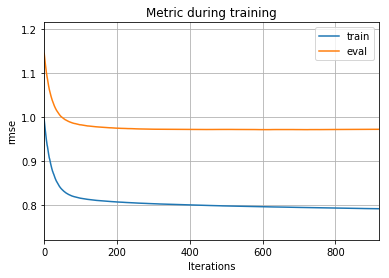

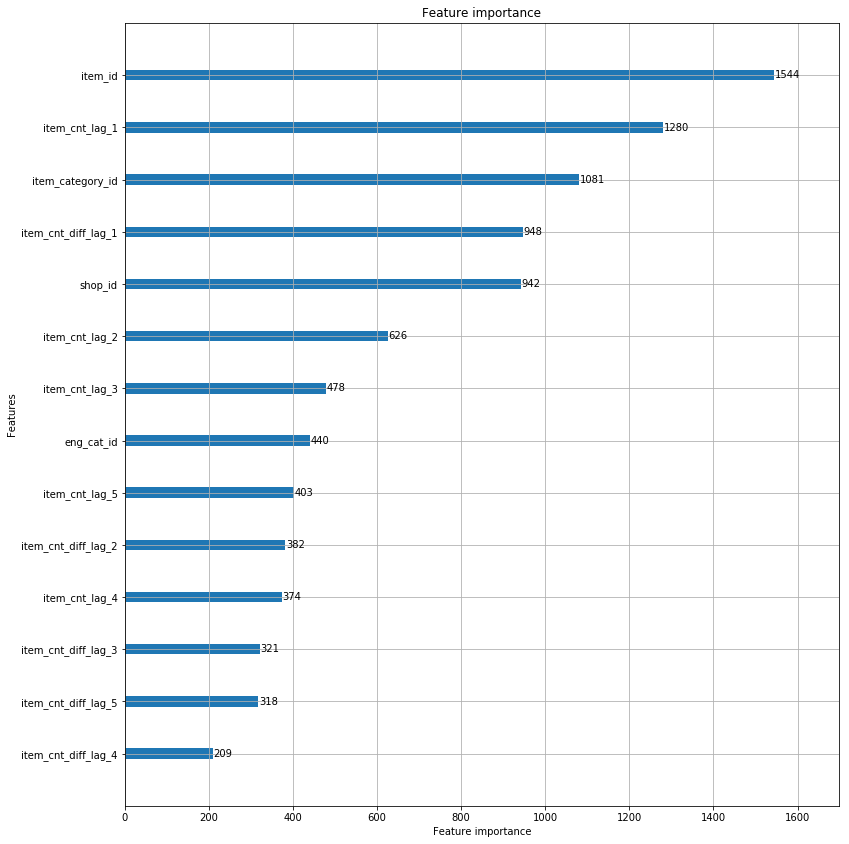

In [33]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
#plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_train.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

# Analyse misprediction in validation

In [34]:
y_val_pred = model.predict(x_val)
y_diff = np.abs(y_val - y_val_pred)
y_diff.describe()               

count    424124.000000
mean          0.282616
std           0.929208
min           0.000031
25%           0.056748
50%           0.078627
75%           0.151841
max          19.943723
Name: 22, dtype: float64

In [42]:
x_val['target'] = y_val
x_val['pred'] = y_val_pred
x_val['mispred diff'] = np.abs(x_val['target'] - x_val['pred'])
x_val[x_val['mispred diff']>5]
print x_val[x_val['mispred diff']>5].shape[0]

2273


# Predict with test data¶

In [36]:
preds = model.predict(x_test)

In [37]:
# Clip prediction to [0-20]
preds = np.clip(preds,0,20)

In [38]:
submit = pd.DataFrame({'ID':data['test'].ID,'item_cnt_month': preds })
submit.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.241537
std,61834.358168,0.666704
min,0.000000,0.021250
25%,53549.750000,0.076461
50%,107099.500000,0.098359
75%,160649.250000,0.162090
max,214199.000000,20.000000


total sales pred: 51737.2968122218 , mean: 0.24153733339039124


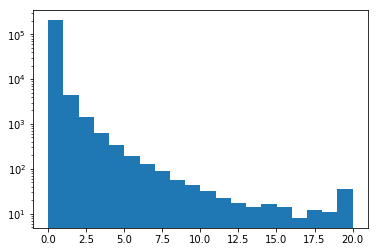

In [39]:
print 'total sales pred:',np.sum(preds), ', mean:',np.mean(preds)
hist_pred = plt.hist(preds,bins=20,log=True)

# Validation with yearly trend

total sales count from Oct23-2018_3 prediction: 51737.2968122218
total sales count from contant 0.5 prediction: 107100.0


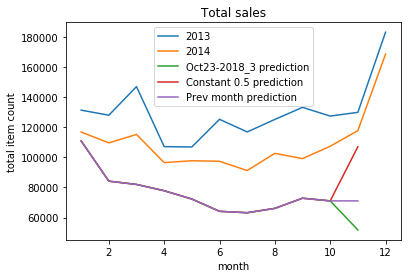

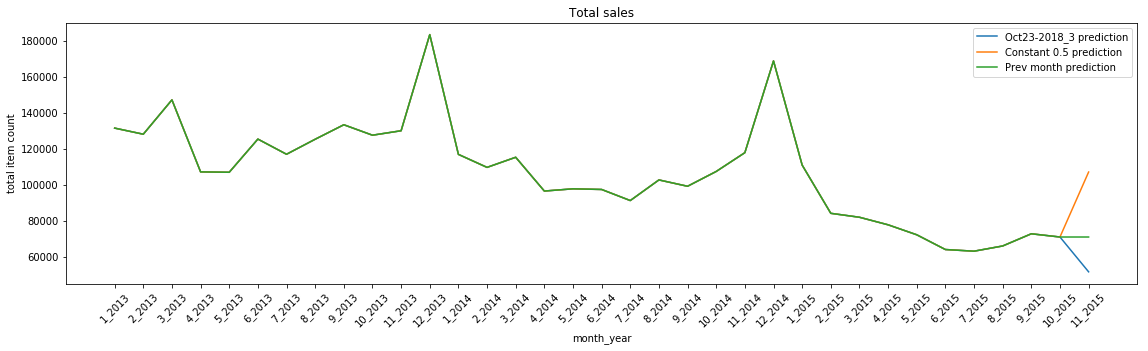

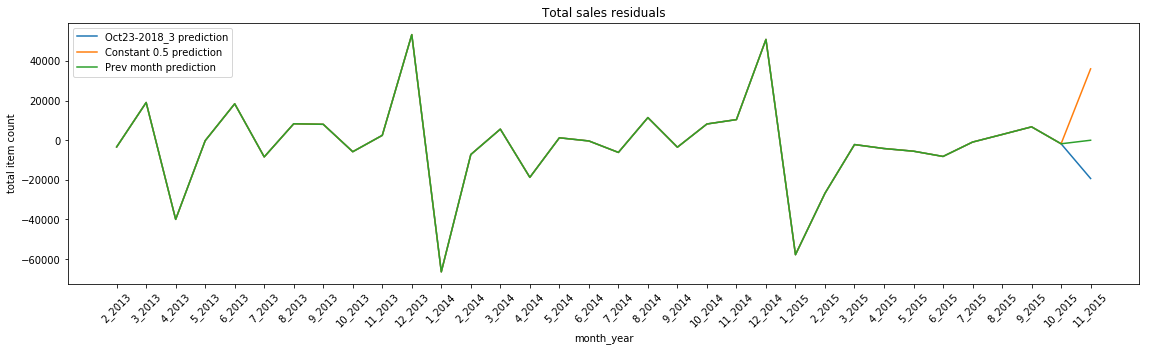

In [40]:
y_test = pd.DataFrame(preds,columns=['item_cnt_month'])

total_item_cnt_2013 = data['sales_2013'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = data['sales_2014'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = data['sales_2015'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

kwargs = {'yearlySales':yearlySales,
        'y_test':y_test,
        'saveName':saveName,
        'saveplots':saveplots,
        'saveFolder':saveFolder}

ut.plotYearly(**kwargs)
ut.plotYearly_v2(**kwargs)
ut.plotResidual(**kwargs)

# Prepare submission file

In [41]:
submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):
    submit.to_csv(saveFolder+'/'+'submit_'+submitName+'.csv',index=False)